In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torchvision import models, transforms
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image

# 设置随机种子以确保可重复性
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
from sklearn.preprocessing import LabelEncoder

class NPYDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        初始化数据集。
        
        参数:
        - csv_file: 包含图像名和标签的CSV文件的路径。
        - root_dir: 包含.npy文件的目录的路径。
        - transform: 应用于图像的转换（可选）。
        """
        try:
            self.annotations = pd.read_csv(csv_file, encoding='utf-8')
        except UnicodeDecodeError:
            self.annotations = pd.read_csv(csv_file, encoding='gbk')
        self.root_dir = root_dir
        self.transform = transform
        self.le = LabelEncoder()
        # 清理和转换标签
        self.annotations['labels'] = self.annotations['labels'].apply(lambda x: x.strip("[]'"))
        self.annotations['labels'] = self.le.fit_transform(self.annotations['labels'])

    def __len__(self):
        """
        返回数据集中的样本数量。
        """
        return len(self.annotations)

    def __getitem__(self, index):
        """
        检索数据集中的第`index`个样本。
        
        参数:
        - index: 要检索的样本的索引。
        
        返回:
        - 一个包含图像和标签的元组。
        """
        # 构建图像文件的完整路径
        img_name = str(self.annotations.iloc[index, -1]) + '.npy'
        img_path = os.path.join(self.root_dir, img_name)
        # 加载图像数据
        image = np.load(img_path).astype(np.float32)
        
        # 确保图像是三通道的
        if image.shape[-1] != 3:
            raise ValueError(f"Expected image to have 3 channels, got {image.shape[-1]}")

        # 将图像数据缩放到[0, 255]区间并转换为uint8
        image = np.clip(image, 0, 1)  # 假设图像数据已经被归一化到[0, 1]区间
        image = (image * 255).astype(np.uint8)
        
        if self.transform:
            # 对于PIL来说需要转换成RGB格式
            image = Image.fromarray(image, 'RGB')
            image = self.transform(image)
        
        label = self.annotations.iloc[index, 2]
        return image, label

# 定义模型
class Inception2D(nn.Module):
    def __init__(self, num_classes, aux_logits=True):
        super(Inception2D, self).__init__()
        self.inception = models.inception_v3(pretrained=True, aux_logits=aux_logits)
        # 替换原始分类器
        self.inception.AuxLogits.fc = nn.Linear(self.inception.AuxLogits.fc.in_features, num_classes)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)

    def forward(self, x):
        if self.training and self.inception.aux_logits:
            return self.inception(x)
        else:
            return self.inception(x)
# 训练和评估参数
num_epochs = 5
batch_size = 32
learning_rate = 0.001

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 转换函数，适应Inception模型的输入尺寸
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 初始化数据集和数据加载器
train_dataset = NPYDataset(csv_file='/kaggle/input/version2ai-in-eye-diseases/train.csv', root_dir='/kaggle/input/version2ai-in-eye-diseases/normalized_train_images/normalized_train_images', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = NPYDataset(csv_file='/kaggle/input/version2ai-in-eye-diseases/test.csv', root_dir='/kaggle/input/version2ai-in-eye-diseases/normalized_test_images/normalized_test_images', transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

validation_dataset = NPYDataset(csv_file='/kaggle/input/version2ai-in-eye-diseases/validation.csv', root_dir='/kaggle/input/version2ai-in-eye-diseases/normalized_validation_images/normalized_validation_images', transform=transform)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
# 模型初始化
num_classes = len(np.unique(train_dataset.annotations['labels']))
model = Inception2D(num_classes=num_classes).to(device)

# 损失函数和优化器
weights = torch.tensor([1.0, 1.2, 1.0, 1.0], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

# 学习率调度器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from torchvision import transforms

# 假设 train_loader, val_loader, 和 test_loader 已经被正确创建并可用
# train_loader = DataLoader(...)
# val_loader = DataLoader(...)
# test_loader = DataLoader(...)
model.to(device)
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  
                data_loader = train_loader
            else:
                model.eval()   
                data_loader = validation_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).long()  # 转换为长整型

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # 对Inception模型的处理，如果有必要的话
                    if hasattr(outputs, 'logits'):
                        outputs = outputs.logits
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        test_loss, test_acc = evaluate(model, test_loader, criterion)
        print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}\n')

    return model

def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(data_loader.dataset)
    total_acc = running_corrects.double() / len(data_loader.dataset)

    return total_loss, total_acc

# 在此基础上调用 train_model 函数以开始训练和测试过程
# 请确保你已经定义了 model, criterion, optimizer, scheduler, 和 train_loader, val_loader, test_loader
# 例如: model = Inception2D(num_classes=num_classes).to(device)
model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.7132 Acc: 0.6888
validation Loss: 2.2022 Acc: 0.4430
Test Loss: 1.9300 Acc: 0.4799

Epoch 2/10
----------
train Loss: 0.5889 Acc: 0.7558
validation Loss: 0.6287 Acc: 0.7148
Test Loss: 0.6186 Acc: 0.7248

Epoch 3/10
----------
train Loss: 0.5297 Acc: 0.7586
validation Loss: 0.6867 Acc: 0.7483
Test Loss: 0.6184 Acc: 0.7483

Epoch 4/10
----------
train Loss: 0.4283 Acc: 0.8098
validation Loss: 0.5294 Acc: 0.7819
Test Loss: 0.5372 Acc: 0.7517

Epoch 5/10
----------
train Loss: 0.3427 Acc: 0.8610
validation Loss: 1.4766 Acc: 0.5973
Test Loss: 1.7861 Acc: 0.5570

Epoch 6/10
----------
train Loss: 0.2788 Acc: 0.8876
validation Loss: 0.8050 Acc: 0.7181
Test Loss: 0.7954 Acc: 0.7215

Epoch 7/10
----------
train Loss: 0.2401 Acc: 0.9085
validation Loss: 0.6747 Acc: 0.7752
Test Loss: 0.7456 Acc: 0.7752

Epoch 8/10
----------
train Loss: 0.2106 Acc: 0.9287
validation Loss: 0.8198 Acc: 0.7215
Test Loss: 0.7820 Acc: 0.7248

Epoch 9/10
----------
train Loss: 0.1783

In [13]:
def calculate_class_accuracy(model, data_loader, num_classes):
    model.eval()
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                label = labels[i]
                pred = preds[i]
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1

    # 打印每个类别的准确率
    for i in range(num_classes):
        if class_total[i] > 0:
            print(f'Accuracy of class {i}: {class_correct[i] / class_total[i] * 100:.2f}%')
        else:
            print(f'Class {i} has no samples in the dataset')

# 在模型训练和测试之后，调用calculate_class_accuracy函数
# 确保已经定义了test_loader和num_classes
calculate_class_accuracy(model, test_loader, num_classes)

Accuracy of class 0: 96.39%
Accuracy of class 1: 71.62%
Accuracy of class 2: 84.62%
Accuracy of class 3: 69.74%


In [14]:
# Assuming `le` is your LabelEncoder instance that has been fitted to the labels
print("Label mapping:")
for i, label in enumerate(train_dataset.le.classes_):
    print(f"{label}: {i}")

Label mapping:
C: 0
D: 1
M: 2
N: 3


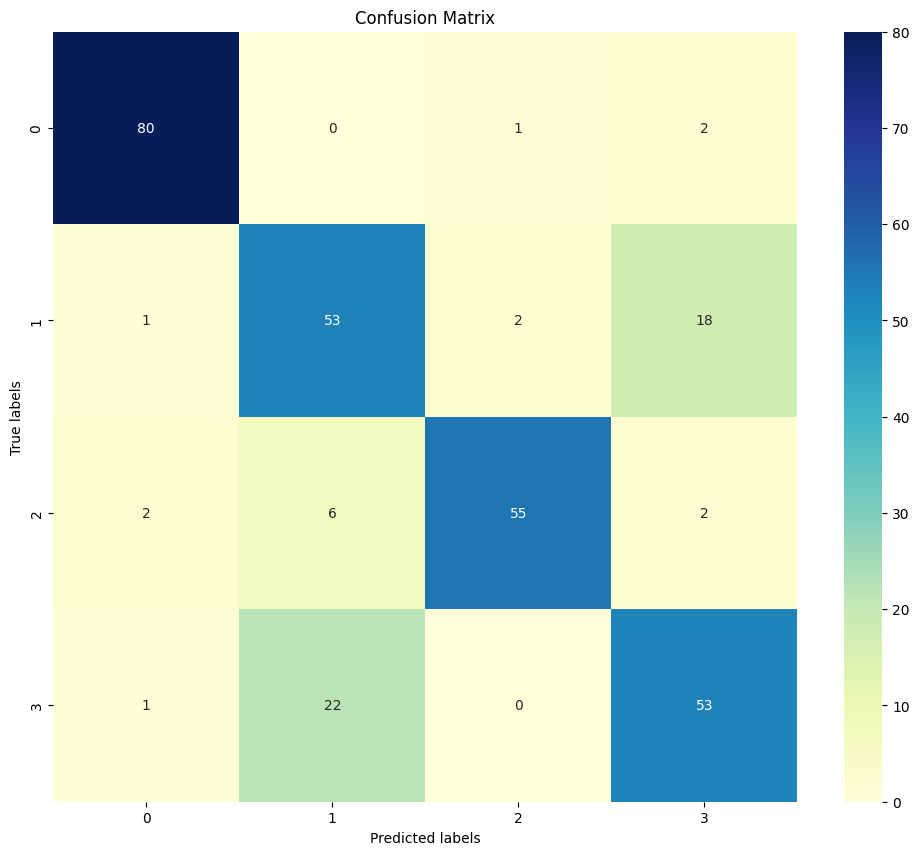

In [15]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 假设test_loader是你的测试数据加载器
# 假设model是你的PyTorch模型
model.eval()  # 设置模型为评估模式

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
num_classes = len(np.unique(all_labels))

# 绘制混淆矩阵的热力图
plt.figure(figsize=(12, 10))  # 根据需要调整图像的大小
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()